In [1]:
# Run this cell only once then delete it, this just a relacement for running pip install olfpy
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    
install('odfpy')
install('keras')

In [2]:
import scipy
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import warnings
import csv

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
def load_data_part1():
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    # Emission Data (CO2)
    EU_em_df = pd.read_excel('Data/EU_em.xlsx',engine='openpyxl')
    EU_em_annual_df = pd.read_csv('Data/EU_em_annual.csv',)
    UK_em_df = pd.read_excel('Data/UK_em.ods', nrows = 16)
    US_em_df = pd.read_excel('Data/US_em.xlsx',engine='openpyxl')
        # Emissions data Processing
    EU_em_df = EU_em_df.set_index('Month')
    UK_em_df = UK_em_df.transpose()
    
    # Electric Vehicles
    EU_veh_df = pd.read_csv('Data/EU_veh.csv')
    UK_veh_df = pd.read_excel('Data/UK_veh.ods', nrows= 76)
    US_veh_df = pd.read_excel('Data/US_veh.xlsx',engine='openpyxl')
    return EU_em_df, EU_em_annual_df, UK_em_df, US_em_df, EU_veh_df,UK_veh_df, US_veh_df

EU_em_df, EU_em_annual_df, UK_em_df, US_em_df, EU_veh_df,UK_veh_df, US_veh_df = load_data_part1()

def load_data_part2():
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    # Secondary Data 
        # Air pollution
            # UK 1970-2019/2022
    UK_nox_annual_df = pd.read_csv('Data/Figure06_NOx_time_series.csv')
    UK_pm_all_annual_df = pd.read_csv('Data/Figure03_PM_time_series.csv')
            
            # USA Since 1970-2020, plz Access through column id(numbers)
    USA_nox_annual_df = pd.read_csv('Data/US_nox_em_time_series.csv') # National Emissions Totals (thousands of tons)
    USA_pm_10_annual_df = pd.read_csv('Data/US_pm10_year.csv')        #
    USA_pm_2_5_annual_df = pd.read_csv('Data/US_pm2_5_year.csv')
    
    USA_pm_2_5_annual_df = USA_pm_2_5_annual_df.transpose()
    USA_pm_10_annual_df = USA_pm_10_annual_df.transpose()
            
            # OCED DATA
    OCED_PM10_df = pd.read_excel('Data/PM10_ROAD_OCED_WORLD_DATA.xlsx',engine='openpyxl')
    OCED_NOX_df = pd.read_excel('Data/NOX_ROAD_OCED_WORLD_DATA.xlsx',engine='openpyxl')
    OCED_PM2_5_df = pd.read_excel('Data/PM2_5_ROAD_OCED_WORLD_DATA.xlsx',engine='openpyxl')
    
    return UK_nox_annual_df,UK_pm_all_annual_df,USA_pm_10_annual_df,USA_pm_2_5_annual_df,USA_nox_annual_df,OCED_PM10_df,OCED_NOX_df,OCED_PM2_5_df
    
UK_nox_annual_df,UK_pm_all_annual_df,USA_pm_10_annual_df,USA_pm_2_5_annual_df,USA_nox_annual_df,OCED_PM10_df,OCED_NOX_df,OCED_PM2_5_df = load_data_part2()

# Eric: Simpler ways to read the data
# calling head() method  
# storing in new variable 
data_top = US_veh_df
    
# display 
data_top 

,Model Year,1992,1993,1994,1995,1996,1997,1998,1999,2000,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,Unnamed: 29
0,Hydrogen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,9.0,0.0,1.0,21.0,24.0,9.0,NaN
1,CNG,11.0,1637.0,2617.0,3513.0,2322.0,2208.0,1890.0,3029.0,3811.0,...,496.0,618.0,1224.0,1228.0,891.0,644.0,546.0,440.0,534.0,NaN
2,E85,0.0,102.0,92.0,185.0,474.0,1734.0,2105.0,3500.0,8469.0,...,13681.0,17153.0,19016.0,18700.0,19282.0,20123.0,18731.0,17283.0,18622.0,NaN
3,LNG,0.0,0.0,2.0,0.0,3.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,Propane,0.0,560.0,1281.0,1603.0,1641.0,1545.0,1351.0,731.0,1370.0,...,1.0,21.0,8.0,0.0,4.0,1.0,12.0,12.0,10.0,NaN
5,Methanol (M85),0.0,132.0,56.0,23.0,130.0,579.0,401.0,149.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
6,Other Bioderived Fuels,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,9.0,3.0,13.0,48.0,36.0,NaN
7,Electric,16.0,52.0,171.0,117.0,56.0,251.0,372.0,595.0,349.0,...,318.0,208.0,194.0,403.0,592.0,652.0,678.0,854.0,1710.0,NaN
8,Total,27.0,2483.0,4219.0,5441.0,4626.0,6317.0,6119.0,8005.0,13999.0,...,14496.0,18000.0,20445.0,20340.0,20778.0,21424.0,20001.0,18661.0,20921.0,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
def produce_predictions_linear_regression(train_X, train_y):
    # data fitting
    model = LinearRegression().fit(train_X, train_y)
    # make predictions
    regression = model.predict(train_X)
    return regression,model

In [5]:
def to_do_normal(dataset):
    # Using a MinMax Scaler to normalize the data;
    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_dataset = scaler.fit_transform(dataset)
    normalized_dataset = normalized_dataset + 1 # avoid zeros;
    return normalized_dataset

In [6]:
def to_do_denormal(normalized_predictions,original_y):
    # Assuming the data and predictions were normalized via MinMax Scaler then +1, denormalized them;
    normalized_predictions = normalized_predictions.reshape(-1,1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    non_used_normalized_y = scaler.fit_transform(original_y)
    normalized_predictions = normalized_predictions - 1
    denormalized_dataset = scaler.inverse_transform(normalized_predictions)
    return denormalized_dataset

In [7]:
def data_transpose(xx):
    xx = xx.transpose()
    xx = xx[0]
    return xx

In [8]:
def mean_squared_percentage_error(y_true, y_pred): 
    MSPE = np.mean(mean_squared_error(y_true,y_pred,squared = True)/y_true) * 100
    return np.abs(MSPE)

In [9]:
def Rsqaured_test(predictions,true):
    abs_error = predictions - true
    R2 = 1.0 - (np.var(abs_error) / np.var(true))
    return R2

In [10]:
# "offset" is the term for absolute deviation or some times the "vertical above and below deviations" of y in regression analysis.

# A order 2 polynomial function.
def x2_function(x, offset, rate_of_change_1,rate_of_change_2,rate_of_change_3): 
    y = offset +(rate_of_change_1*x)+(rate_of_change_2 * (np.square(x)))+(rate_of_change_3*(np.power(x,3)))
    return y

# Sigmoid Function developed from similar example used in Biology to investigate population growth.
def sigmoid_function(x, offset, averageY, rate_of_change, time_max): 
    y = offset + (averageY - offset) / (1 + np.exp(-rate_of_change*(x-time_max)))
    return y

# Sine Function to test if there is a repeating trend;
def sine_function(x, vertical_offset, horizontal_offset, multipler): 
    y = vertical_offset + multipler*(np.sin(x+horizontal_offset))
    return y

In [11]:
# function to optimise a sigmoid model
def sigmoid_model(x,y):
    bounds = []
    bounds.append([0.0, max(y)])    # bounds of the offset 
    bounds.append([min(y), max(y)]) # bounds of the average y
    bounds.append([min(x), max(x)]) # bounds of the rate of change
    bounds.append([min(x), max(x)]) # bounds of the maximum time of the change
    def calc_epsilon(parameterTuple):
        val = sigmoid_function(x, *parameterTuple)
        return np.sum(np.abs(np.square(y) - np.square(val)))
    # Optimisation via differential evolution.
    optimized = differential_evolution(calc_epsilon, bounds, seed=0, tol=0.00001)
    return optimized.x

# function to optimise a x2 model
def x2_model(x,y):
    bounds = []
    bounds.append([0.0, max(y)])    # bounds of the offset;
    bounds.append([0.0, max(x)]) # bounds of the rate of change 1, maximum will make rate of change 1*x = x^2;
    bounds.append([0.0, max(x)]) # bounds of the rate of change 2, maximum will make rate of change 2*x = x^3;
    bounds.append([0.0, max(x)]) # bounds of the rate of change 3, maximum will make rate of change 3*x = x^4;
    def calc_epsilon(parameterTuple):
        val = x2_function(x, *parameterTuple)
        return np.sum(np.abs(np.square(y) - np.square(val)))
    # Optimisation via differential evolution.
    optimized = differential_evolution(calc_epsilon, bounds, seed=0, tol=0.00001)
    return optimized.x

# function to optimise a sine model
def sine_model(x,y):
    bounds = []
    bounds.append([min(y), max(y)]) # bounds of the vertical offset;
    bounds.append([min(x), max(x)]) # bounds of the horizontal offset;
    bounds.append([-np.absolute(np.mean(x)), np.absolute(np.mean(x))]) # bounds of the multipler;
    def calc_epsilon(parameterTuple):
        val = sine_function(x, *parameterTuple)
        return np.sum(np.abs(np.square(y) - np.square(val)))
    # Optimisation via differential evolution.
    optimized = differential_evolution(calc_epsilon, bounds, seed=0, tol=0.00001)
    return optimized.x

In [12]:
###########
## Extract the 5 countries' 1993 - 2019's Electrical Vehicle registeration's data and CO2 emissions' data from their repective datasets
##########
# British Data Extraction
ElectricCars = UK_veh_df['Hybrid Electric 1'][:27]+UK_veh_df['Plug-in Hybrid Electric 2'][:27]+UK_veh_df['Battery Electric'][:27]+UK_veh_df['Range-Extended Electric 3'][:27]+UK_veh_df['Fuel Cell Electric 4'][:27]
electric_car_dat = np.array(ElectricCars[:-1]).reshape(-1,1)
road_emission_by_veh = np.array(UK_em_df[6][5:]).reshape(-1,1)

# American data Extraction
US_em_df_transpose = US_em_df.transpose()
US_veh_df_transpose = US_veh_df.transpose()

us_car_emission = US_em_df_transpose[1][4:]+US_em_df_transpose[6][4:]+US_em_df_transpose[11][4:]+US_em_df_transpose[16][4:]+US_em_df_transpose[21][4:]
us_car_emission = np.array(us_car_emission)
us_car_emission = us_car_emission.reshape(-1,1)

us_electric_veh = US_veh_df_transpose[8][2:-1]
us_electric_veh = np.array(us_electric_veh)
us_electric_veh = us_electric_veh.reshape(-1,1)
# French data Extraction

# Spainish data Extraction

# Japanese data Extraction

In [13]:
###########
## Data Normalization for rescaling purposes, aiding the stability of Regression models.
##########

# Normalizing British datasets. 
uk_E_car_dat_n = to_do_normal(electric_car_dat)
uk_emission_by_veh_n = to_do_normal(road_emission_by_veh)

    # Transpose to change the row vectors into column vectors for further computation. 
uk_E_car_dat_t = data_transpose(uk_E_car_dat_n)
uk_emission_by_veh_t = data_transpose(uk_emission_by_veh_n)

# Normalizing American datasets.
usa_E_car_dat_n = to_do_normal(us_electric_veh)
usa_emission_by_veh_n = to_do_normal(us_car_emission)

    # Transpose to change the row vectors into column vectors for further computation.

xx = usa_E_car_dat_n.transpose()
xx = xx[0]
yy = usa_emission_by_veh_n.transpose()
yy = yy[0]
    
# Normalizing French datasets

    # Transpose to change the row vectors into column vectors for further computation.

# Normalizing Spainish datasets

    # Transpose to change the row vectors into column vectors for further computation.
    
# Normalizing Japanese datasets

    # Transpose to change the row vectors into column vectors for further computation.

In [14]:
# Plot the model 
def plot_predictons(xx,yy,predictions,model_name):
    plt.scatter(xx, yy)
    plt.plot(xx, predictions, c='r', linewidth=2, label=model_name+' predictions')
    plt.legend()
    figure = plt.gcf()
    figure.set_size_inches(6,5)
    plt.legend(loc=2, prop={'size': 15})
    plt.tight_layout()
    plt.savefig(model_name+'.png')
    plt.xlabel('Normalized Electrical Vehicle Registed')
    plt.ylabel('Normalized Carbon Dioxide Emission')

In [15]:
# Plot the predictions
def plot_predictions(original_true_values,normalized_true_values,predictions,figure_name):
    plt.rcParams.update({'font.size': 15})
    days = list(range(1,len(original_true_values)+1))
    plt.plot(days,to_do_denormal(predictions,original_true_values),c='r',linestyle ="-",label='Predictions')
    plt.plot(days,to_do_denormal(normalized_true_values,original_true_values),c='b',linestyle =":",label='Data')
    plt.legend()
    plt.xlabel('Years Count')
    plt.ylabel('Carbon Emission')
    figure = plt.gcf()
    figure.set_size_inches(10,4)
    plt.legend(loc=2, prop={'size': 20})
    plt.tight_layout()
    plt.savefig(figure_name+'.png')
    plt.show()

In [16]:
# Create an empty list to store MSPE values
x2_MSPE = []
sigmoid_MSPE = []

# Create an empty list to store R Square Values
x2_Rsquared = []
sigmoid_Rsquared = []

MSE in Percentage: 1.5101112151932459
R-squared: 0.6787712880698284


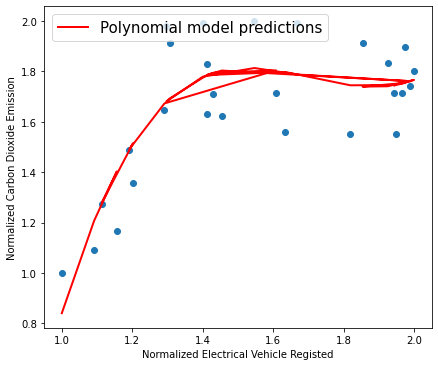

In [17]:
# Fit the function to the data.
usa_x2_model_prameters = x2_model(xx,yy)
# Build the model further by adjusting the paramters to data points
usa_x2_curve, pcov = curve_fit(x2_function, xx, yy, usa_x2_model_prameters) 
# Make predictions
usa_x2_predictions = x2_function(xx, *usa_x2_curve) 
##########################################################
plot_predictons(xx,yy,usa_x2_predictions,'Polynomial model')
USAX2_MSPE = mean_squared_percentage_error(yy,usa_x2_predictions) # Root Mean Squared Error, RMSE
USAX2_Rsquared = Rsqaured_test(usa_x2_predictions,yy)
print('MSE in Percentage:', USAX2_MSPE)
print('R-squared:', USAX2_Rsquared)

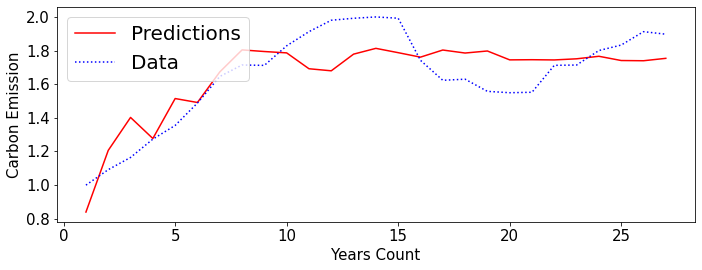

In [18]:
plot_predictions(usa_emission_by_veh_n,yy,usa_x2_predictions,'USAX2_predictions')

MSE in Percentage: 1.78215154922708
R-squared: 0.6209032547650197


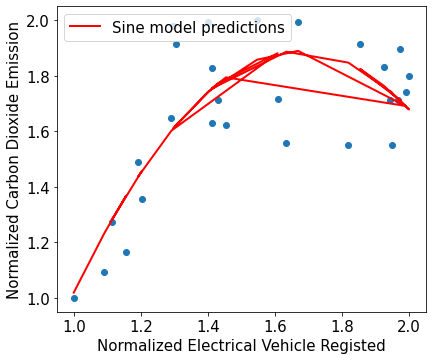

In [19]:
# Fit the function to the data.
usa_sin_model_prameters = sine_model(xx,yy)
# Build the model further by adjusting the paramters to data points
usa_sin_curve, pcov = curve_fit(sine_function, xx, yy, usa_sin_model_prameters) 
# Make predictions
usa_sin_predictions = sine_function(xx, *usa_sin_curve) 
##########################################################
plot_predictons(xx,yy,usa_sin_predictions,'Sine model')
USASIN_MSPE = mean_squared_percentage_error(yy,usa_sin_predictions) # Root Mean Squared Error, RMSE
USASIN_Rsquared = Rsqaured_test(usa_sin_predictions,yy)
print('MSE in Percentage:', USASIN_MSPE)
print('R-squared:', USASIN_Rsquared)

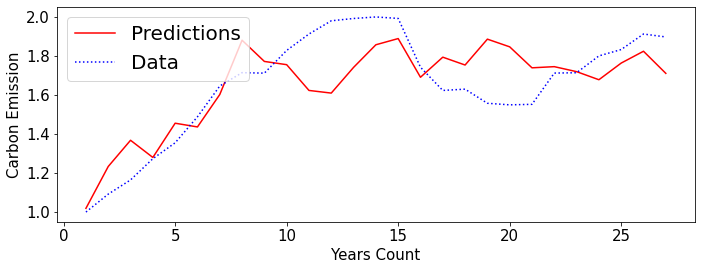

In [20]:
plot_predictions(usa_emission_by_veh_n,yy,usa_sin_predictions,'USASIN_predictions')

MSE in Percentage: 1.2312191899179177
R-squared: 0.7380968033997098


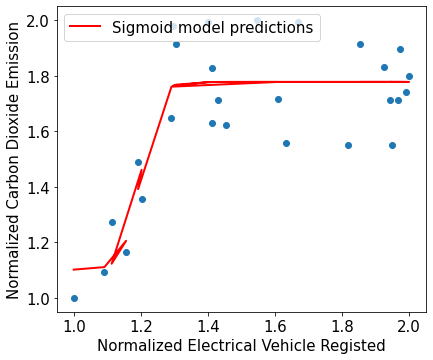

In [21]:
# Fit the function to the data.
usa_sigmoid_parameters = sigmoid_model(xx,yy)
# Build the model further by adjusting the paramters to data points
usa_sigmoid_curve, pcov = curve_fit(sigmoid_function, xx, yy, usa_sigmoid_parameters)
# Make predictions
usa_sig_predictions = sigmoid_function(xx, *usa_sigmoid_curve) 
##########################################################
plot_predictons(xx,yy,usa_sig_predictions,'Sigmoid model')
USASig_MSPE = mean_squared_percentage_error(yy,usa_sig_predictions) # Root Mean Squared Error, RMSE
USASig_Rsquared = Rsqaured_test(usa_sig_predictions,yy)
print('MSE in Percentage:', USASig_MSPE)
print('R-squared:', USASig_Rsquared)

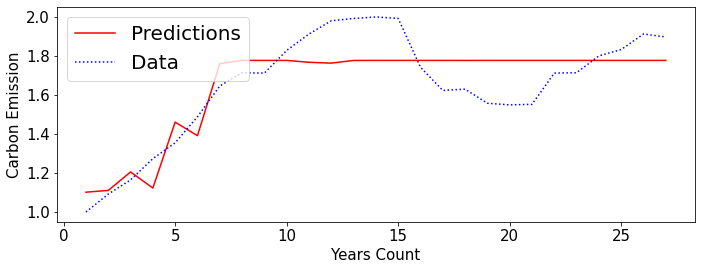

In [22]:
plot_predictions(usa_emission_by_veh_n,yy,usa_sig_predictions,'USASig_predictions')

MSE in Percentage: 2.4336984530350048
R-squared: 0.5831690966492318


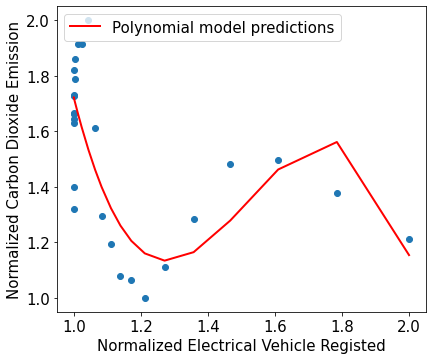

In [23]:
# generate initial parameter values
uk_x2_parameters = x2_model(uk_E_car_dat_t,uk_emission_by_veh_t)
# Build the model further by adjusting the paramters to data points
uk_x2_curve, pcov = curve_fit(x2_function, uk_E_car_dat_t, uk_emission_by_veh_t, uk_x2_parameters)
# Make predictions
uk_x2_predictions = x2_function(uk_E_car_dat_t, *uk_x2_curve) 
##########################################################
plot_predictons(uk_E_car_dat_t,uk_emission_by_veh_t,uk_x2_predictions,'Polynomial model')
UKX2_MSPE = mean_squared_percentage_error(uk_emission_by_veh_t,uk_x2_predictions) # Root Mean Squared Error, RMSE
UKX2_Rsquared = Rsqaured_test(uk_x2_predictions,uk_emission_by_veh_t)
print('MSE in Percentage:', UKX2_MSPE)
print('R-squared:', UKX2_Rsquared)

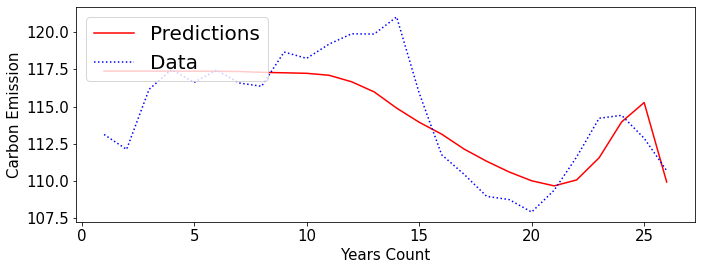

In [24]:
plot_predictions(road_emission_by_veh,uk_emission_by_veh_t,uk_x2_predictions,'UKX2_predictions')

MSE in Percentage: 22.897047418447755
R-squared: -2.1998511363767257


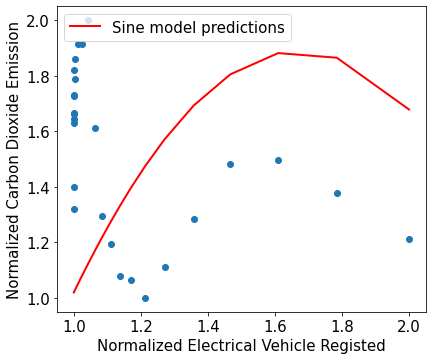

In [25]:
# Fit the function to the data.
uk_sin_model_prameters = sine_model(uk_E_car_dat_t,uk_emission_by_veh_t)
# Build the model further by adjusting the paramters to data points
uk_sin_curve, pcov = curve_fit(sine_function, uk_E_car_dat_t, uk_emission_by_veh_t, usa_sin_model_prameters) 
# Make predictions
uk_sin_predictions = sine_function(uk_E_car_dat_t, *usa_sin_curve) 
##########################################################
plot_predictons(uk_E_car_dat_t,uk_emission_by_veh_t,uk_sin_predictions,'Sine model')
UKSIN_MSPE = mean_squared_percentage_error(uk_emission_by_veh_t,uk_sin_predictions) # Root Mean Squared Error, RMSE
UKSIN_Rsquared = Rsqaured_test(uk_sin_predictions,uk_emission_by_veh_t)
print('MSE in Percentage:', UKSIN_MSPE)
print('R-squared:', UKSIN_Rsquared)

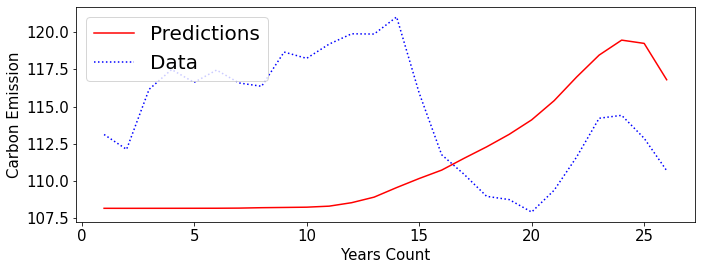

In [26]:
plot_predictions(road_emission_by_veh,uk_emission_by_veh_t,uk_sin_predictions,'UKSIN_predictions')

MSE in Percentage: 1.9865781779955467
R-squared: 0.6597494749285207


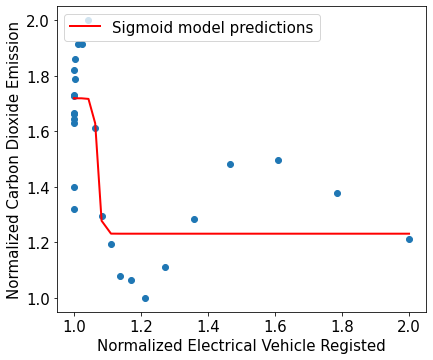

In [27]:
# generate initial parameter values
uk_sigmoid_parameters = sigmoid_model(uk_E_car_dat_t,uk_emission_by_veh_t)
# Build the model further by adjusting the paramters to data points
uk_sigmoid_curve, pcov = curve_fit(sigmoid_function, uk_E_car_dat_t, uk_emission_by_veh_t, uk_sigmoid_parameters)
# Make predictions
uk_sig_predictions = sigmoid_function(uk_E_car_dat_t, *uk_sigmoid_curve) 
##########################################################
plot_predictons(uk_E_car_dat_t,uk_emission_by_veh_t,uk_sig_predictions,'Sigmoid model')
UKSig_MSPE = mean_squared_percentage_error(uk_emission_by_veh_t,uk_sig_predictions) # Root Mean Squared Error, RMSE
UKSig_Rsquared = Rsqaured_test(uk_sig_predictions,uk_emission_by_veh_t)
print('MSE in Percentage:', UKSig_MSPE)
print('R-squared:', UKSig_Rsquared)

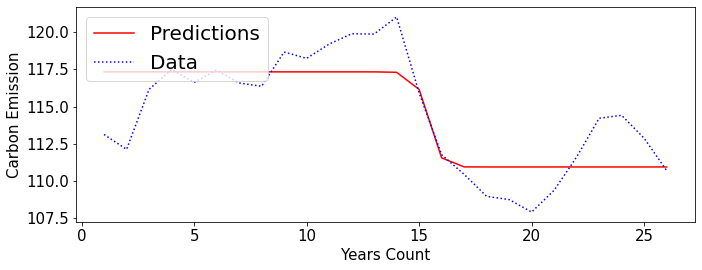

In [28]:
plot_predictions(road_emission_by_veh,uk_emission_by_veh_t,uk_sig_predictions,'UKSig_predictions')

In [212]:
with open('C:/Users/Liu2286/Documents/GitHub/EV_affect_on_emissions/Outputs/NLR_model_outputs.csv', 'w') as f:
    # create the csv writer
    writer = csv.writer(f)
    # write a row to the csv file
    writer.writerow(['Country','Polynomial Function','','Sine Function','','Sigmoid Function',''])
    writer.writerow(['','MSE (%)','R Square Score (%)','MSE (%)','R Square Score (%)','MSE (%)','R Square Score (%)'])
    writer.writerow(['USA',USAX2_MSPE,USAX2_Rsquared,USASIN_MSPE,USASIN_Rsquared,USASig_MSPE,USASig_Rsquared])
    writer.writerow(['UK',UKX2_MSPE,UKX2_Rsquared,UKSIN_MSPE,UKSIN_Rsquared,UKSig_MSPE,UKSig_Rsquared])